In [799]:
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd
%matplotlib inline

# Loss functions

In [779]:
vgg = models.vgg16(pretrained=True)
mse = nn.MSELoss()

## Content Loss

### Content Image

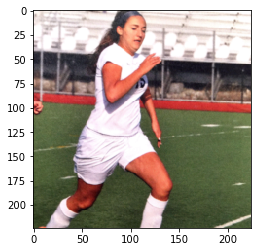

In [780]:
original_image = U.folder[0][0]
U.imshow(original_image)

In [800]:
vgg_avg_pooling = U.convert_to_average_pooling(list(vgg.features)[:12])

In [783]:
def content_loss(generated_image, content_image):
    pred = vgg_avg_pooling.forward(generated_image.unsqueeze(0))
    t = vgg_avg_pooling.forward(content_image.unsqueeze(0))
    t = Variable(t.data)
    return mse(pred, t)

def content_loss_and_gradients(gen_img):
    prediction = Variable(gen_img, requires_grad= True)                                                         
    loss_amt = content_loss(prediction, target)
    loss_amt.backward()                                                                                                                        
    content_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)                                                                      
    c_loss = loss_amt.data.numpy().astype(np.float64)
    return c_loss, content_gradients

## Style Loss

### Style Image

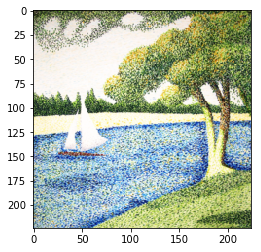

In [784]:
style_image = U.get_image(2,54)
U.imshow(style_image)

In [803]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [2,10,19, 28]
module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
conv_layer_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]

In [785]:
def gram_matrix(x):
    batch_size = x.size()[0]
    height  = x.size()[1]
    width = x.size()[2]
    chan = x.size()[3]
    flattened_channels = x.resize(batch_size, chan, width * height)
    g_matrix = flattened_channels[0].matmul(flattened_channels[0].transpose(1,0)).unsqueeze(0) / x.nelement()
    return g_matrix

def style_loss(model, generated_image_layer, style_image_layer):
    pred = model.forward(generated_image_layer.unsqueeze(0))
    t = model.forward(style_image_layer.unsqueeze(0))
    t = Variable(t.data)
    return mse(gram_matrix(pred), gram_matrix(t))


def style_loss_and_gradients(gen_image):
    prediction = Variable(gen_image, requires_grad= True)                                                         
    loss_amt = sum([ style_loss(model, prediction, Variable(style_image)) for model in conv_layer_models ])
    loss_amt.backward()                                                                                                                        
    style_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)                                                                      
    s_loss = loss_amt.data.numpy().astype(np.float64)
    return s_loss, style_gradients

### Using the content_loss function, recreate our image from random noise

In [786]:
target = Variable(original_image)

noise_tensor = torch.rand(3,224, 224) - 0.5
noise = Variable(noise_tensor, requires_grad= True)

#### Noise starts as

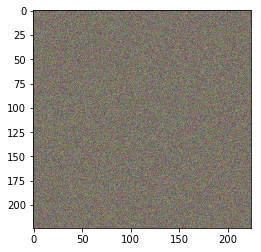

In [787]:
U.imshow(noise_tensor)

# Minimize noise based on vgg output

In [788]:
from scipy.optimize import fmin_l_bfgs_b 

In [791]:
def loss_fn(flattened_image):
    predicted_image = torch.Tensor(flattened_image.reshape(target.size()))
    c_loss, content_gradients = content_loss_and_gradients(predicted_image)
    s_loss, style_gradients = style_loss_and_gradients(predicted_image)
    return s_loss + c_loss,  style_gradients + content_gradients

In [804]:
gen_image = noise.data.numpy().flatten()
for i in range(2):
    generated_image, min_val, y = fmin_l_bfgs_b(loss_fn, gen_image, maxfun=10)
    print("Epoch "+str(i) + " Loss: " +str(min_val))
    gen_image = generated_image

Epoch 0 Loss: [ 1.0752272]
Epoch 1 Loss: [ 0.61634181]


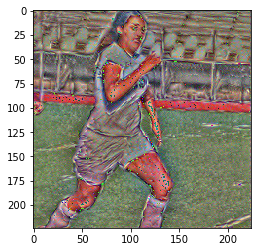

In [805]:
U.imshow(torch.Tensor(gen_image.reshape(target.size())))

In [806]:
for i in range(5):
    generated_image, min_val, y = fmin_l_bfgs_b(loss_fn, gen_image, maxfun=20)
    print("Epoch "+str(i) + " Loss: " +str(min_val))
    gen_image = generated_image

Epoch 0 Loss: [ 0.32094556]
Epoch 1 Loss: [ 0.23128621]
Epoch 2 Loss: [ 0.18069477]
Epoch 3 Loss: [ 0.14374411]
Epoch 4 Loss: [ 0.1217138]


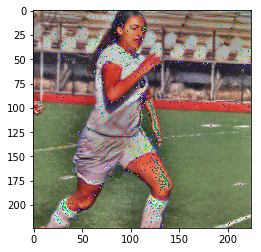

In [808]:
U.imshow(torch.Tensor(gen_image.reshape(target.size())))